## Imports

In [11]:
from inception_resnet_v1 import *
import cv2
import numpy as np
import glob
import h5py
import matplotlib.pyplot as plt

## First Approach

I tried to train face recognition model from scratch using triplet loss cost function, but it requires a very large dataset and alot of computational power to generalize. The training aims to minimize the distance between faces of the same person(anchor and positive images), and maximizing the distance between anchor and negative images.

In [3]:
IMG_SIZE = 160

In [12]:
def add_labels(labels, img_paths):
    for img_path in img_paths:
        if 'seif' in img_path:
            labels.append(0)
        elif 'baba' in img_path:
             labels.append(1)
        elif 'marawan' in img_path:
             labels.append(2)
        else:
            labels.append(3)

In [13]:
f = None
faces_path = './images/*.jpeg' # the original data path

# get all the image paths 
img_paths = glob.glob(faces_path)

labels = []
add_labels(labels, img_paths) 

c = list(zip(img_paths, labels)) # use zip() to bind the images and labels together
(img_paths, labels) = zip(*c)  

f = h5py.File('data.hdf5', mode='w')

train_shape = (len(img_paths), IMG_SIZE, IMG_SIZE, 3)
grey_scale_shape = (len(img_paths), IMG_SIZE, IMG_SIZE)

f.create_dataset("X", train_shape, np.uint8)

f.create_dataset("grey_scale", grey_scale_shape, np.uint8)
f.create_dataset("Y", (len(img_paths),), np.uint8)
f["Y"][...] = labels

In [14]:
for i in range(len(img_paths)):

    addr = img_paths[i]
    img = cv2.imread(addr)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_CUBIC)
    f["grey_scale"][i, ...] = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
    f["X"][i, ...] = img[None] 
     
f.close()

In [15]:
def load_datasets():
    train_dataset = h5py.File('data.hdf5', "r")
    X = np.array(train_dataset["X"][:])
    Y = np.array(train_dataset["Y"][:]) 
    greyscale_X = np.array(train_dataset["grey_scale"][:]) 
    return X,greyscale_X, Y

In [26]:
X,greyscale_X, Y = load_datasets()
X = X / 255
greyscale_X = greyscale_X / 255
greyscale_X = greyscale_X.reshape(greyscale_X.shape[0], -1).T

y = 2


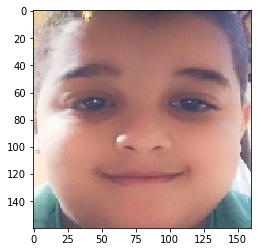

In [19]:
index = 20
plt.imshow(X[index])
print ("y = " + str(np.squeeze(Y[index])))

y = 1


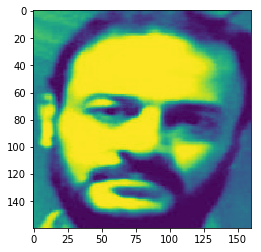

In [24]:
index = 5
plt.imshow(greyscale_X[index])
print ("y = " + str(np.squeeze(Y[index])))

In [17]:
def get_triplets():
    label_l, label_r = np.random.choice(unique_train_label, 2, replace=True)
    a, p = np.random.choice(map_train_label_indices[label_l],2, replace=True)
    n = np.random.choice(map_train_label_indices[label_r])
    return a, p, n

In [9]:
unique_train_label = np.array([])
map_train_label_indices = dict()
unique_train_label = np.unique(Y)
map_train_label_indices = {label: np.flatnonzero(Y == label) for label in
                                        unique_train_label}

In [10]:
def get_triplets_batch(n):
        idxs_a, idxs_p, idxs_n = [], [], []
        for _ in range(n):
            a, p, n = get_triplets()
            idxs_a.append(a)
            idxs_p.append(p)
            idxs_n.append(n)
        return X[idxs_a,:], X[idxs_p, :], X[idxs_n, :]

In [12]:
from keras.layers import Layer
model1 = InceptionResNetV1((160, 160, 3))
# Input for anchor, positive and negative images
in_a = Input(shape=(160, 160, 3))
in_p = Input(shape=(160, 160, 3))
in_n = Input(shape=(160, 160, 3))

# Output for anchor, positive and negative embedding vectors
emb_a = model1(in_a)
emb_p = model1(in_p)
emb_n = model1(in_n)

class TripletLossLayer(Layer):
    def __init__(self, alpha, **kwargs):
        self.alpha = alpha
        super(TripletLossLayer, self).__init__(**kwargs)
    
    def triplet_loss(self, inputs):
        a, p, n = inputs
        p_dist = K.sum(K.square(a-p), axis=-1)
        n_dist = K.sum(K.square(a-n), axis=-1)
        return K.sum(K.maximum(p_dist - n_dist + self.alpha, 0), axis=0)
    
    def call(self, inputs):
        loss = self.triplet_loss(inputs)
        self.add_loss(loss)
        return loss

# Layer that computes the triplet loss from anchor, positive and negative embedding vectors
triplet_loss_layer = TripletLossLayer(alpha=0.2, name='triplet_loss_layer')([emb_a, emb_p, emb_n])

# Model that can be trained with anchor, positive negative images
model= Model([in_a, in_p, in_n], triplet_loss_layer)

In [ ]:
triplets = get_triplets_batch(100)
model.compile(loss= None, optimizer='adam')
model.fit([triplets[0], triplets[1],triplets[2]], epochs=10, batch_size=8)

## Second Approach

The second approach is to use transfer learning and load a model with pretrained weights.

The maximum file size allowed on lms is 20 mb only so i added a link to download facenet_weights.h5 file from google drive in download_weights_link.txt.

In [2]:
model = InceptionResNetV1((160, 160, 3))
model.load_weights('facenet_weights.h5')
 
model.summary()


Model: "inception_resnet_v1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 160, 160, 3)  0                                            
__________________________________________________________________________________________________
Conv2d_1a_3x3 (Conv2D)          (None, 79, 79, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
Conv2d_1a_3x3_BatchNorm (BatchN (None, 79, 79, 32)   96          Conv2d_1a_3x3[0][0]              
__________________________________________________________________________________________________
Conv2d_1a_3x3_Activation (Activ (None, 79, 79, 32)   0           Conv2d_1a_3x3_BatchNorm[0][0]    
_______________________________________________________________________________

In [3]:
def l2_normalize(x):
 return x / np.sqrt(np.sum(np.multiply(x, x)))

In [4]:
def findEuclideanDistance(source_representation, test_representation):
 euclidean_distance = source_representation - test_representation
 euclidean_distance = np.sum(np.multiply(euclidean_distance, euclidean_distance))
 euclidean_distance = np.sqrt(euclidean_distance)
 return euclidean_distance

In [5]:
def preprocess_image(img_path):
    img = cv2.imread(img_path)
    img = cv2.resize(img, (160, 160), interpolation=cv2.INTER_CUBIC)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = np.expand_dims(img, axis=0)
    return (img/255)

Save the encoding of each person's face in a database of encodings, The distance between images of the same person should be less than 1. 

In [6]:
database = {}
database['baba'] = l2_normalize(model.predict(preprocess_image('./images/baba (1).jpeg'))[0,:])
database['marawan'] = l2_normalize(model.predict(preprocess_image('./images/marawan3.jpeg'))[0,:])
database['seif'] = l2_normalize(model.predict(preprocess_image('./images/seif4.jpeg'))[0,:])

In [25]:
def who_is_it(img, database, test_flag):
    
    encoding =  l2_normalize(model.predict(preprocess_image(img))[0,:])

    min_dist = 100
    
    # Loop over the database dictionary's names and encodings.
    for (name, db_enc) in database.items():
        
        # Compute L2 distance between the target "encoding" and the current db_enc from the database. (≈ 1 line)
        euclidean_distance = findEuclideanDistance(encoding, db_enc)
        # If this distance is less than the min_dist, then set min_dist to dist, and identity to name. (≈ 3 lines)
        if euclidean_distance < min_dist:
            min_dist = euclidean_distance
            identity = name
    
    if min_dist > 1:
        identity = 'other'
        if not test_flag:
            print("Not in the database.")
            plt.imshow(preprocess_image(img)[0,:])
    else:
        if not test_flag:
            print ("it's " + str(identity) + ", the distance is " + str(min_dist))
            plt.imshow(preprocess_image(img)[0,:])
    return min_dist, identity

In [16]:
def test():
    pos = 0
    neg = 0
    faces_path = './images/*.jpeg' # the original data path

    # get all the image paths 
    img_paths_test = glob.glob(faces_path)
    for i, img in enumerate(img_paths_test):
        min_dist, identity =  who_is_it(img, database, True)
        if identity in  img or (min_dist > 1 and img.split("\\")[1][0:4] == 'fake'):
            if min_dist > 1 and img[:4] == 'fake':
                print('fake')
            pos+=1
        else:
            neg += 1        
    accuracy = (pos / (pos + neg)) * 100
    return accuracy

In [17]:
print("Accuracy= " + str(test()))

Accuracy= 89.79591836734694


it's seif, the distance is 0.79841083


(0.79841083, 'seif')

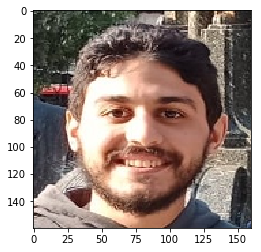

In [27]:
 who_is_it('./images/seif9.jpeg', database, False)

## Last Approch

Using standard classifiers like SVM and multi-layer preceptron on greyscale images.

In [32]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
X_train, X_test, y_train, y_test = train_test_split(greyscale_X.T, Y,test_size=0.3, random_state = 10)

svm_model = SVC(kernel = 'linear', C = 0.1).fit(X_train, y_train.ravel())
yhat = svm_model.predict(X_test)
accuracy = accuracy_score(y_test, yhat)
print(accuracy)

0.6666666666666666


In [40]:
from sklearn.neural_network import MLPClassifier
nn_model = MLPClassifier(alpha=0.01,
                    hidden_layer_sizes=(24,24,24), activation='relu',solver='adam', max_iter=1500).fit(X_train, y_train.ravel())
yhat = nn_model.predict(X_test)
accuracy = accuracy_score(y_test, yhat)
print(accuracy)

0.8


## Code for Data Augmentation

In [12]:
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
datagen = ImageDataGenerator(shear_range=0.2, zoom_range=0.2) 

faces_path = './images/*.jpeg' # the original data path

# get all the image paths 
filenames = glob.glob(faces_path)
for f in filenames:
    img = load_img(f)  
    x = img_to_array(img) 
    # Reshape the input image 
    x = x.reshape((1, ) + x.shape)  
    i = 0

    # generate 5 new augmented images 
    for batch in datagen.flow(x, batch_size = 1, 
                      save_to_dir ='./images/aug',  
                      save_prefix ='car', save_format ='jpeg'):
        i += 1
        if i > 5: 
            break